In [ ]:
from google.colab import drive
import pandas as pd

# Kết nối với Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


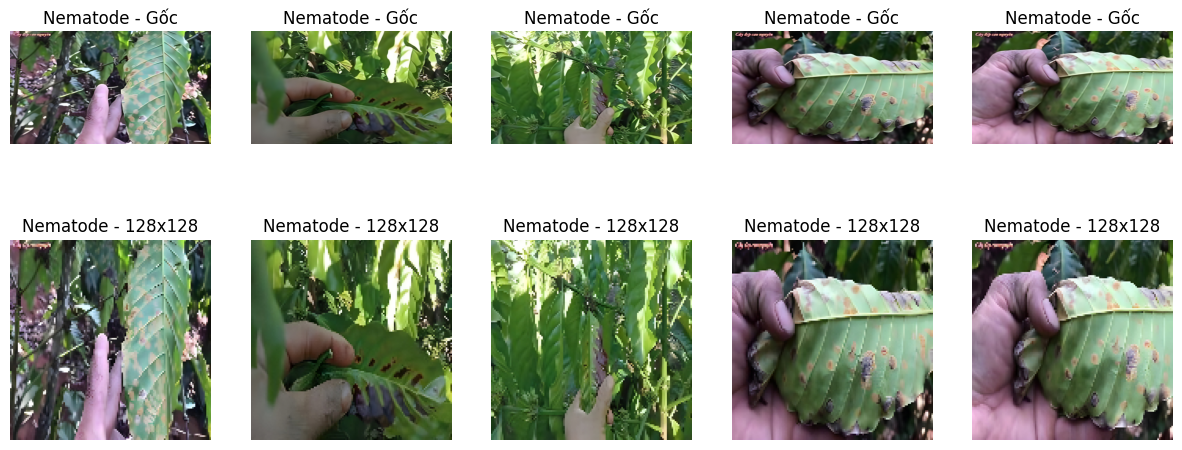

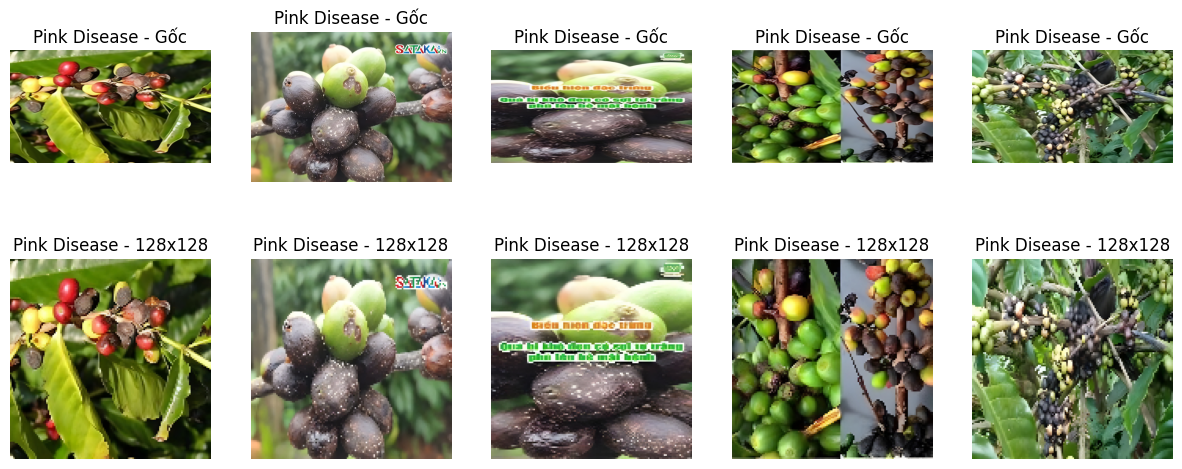

In [ ]:
import cv2
import glob
import os
import matplotlib.pyplot as plt

# 📌 Thư mục chứa ảnh gốc và thư mục chứa ảnh đã resize
input_folder = "/content/drive/MyDrive/resolution/"
output_folder = "/content/drive/MyDrive/dataset_128/"

# 📌 Tạo thư mục output nếu chưa có
os.makedirs(output_folder, exist_ok=True)

# 📌 Duyệt qua từng class
classes = ["Nematode", "Pink Disease"]

for cls in classes:
    input_class_folder = os.path.join(input_folder, cls)
    output_class_folder = os.path.join(output_folder, cls)
    os.makedirs(output_class_folder, exist_ok=True)  # Tạo thư mục class nếu chưa có

    # 📌 Lấy danh sách ảnh trong class
    image_paths = glob.glob(os.path.join(input_class_folder, "*.jpg"))[:5]  # Lấy 5 ảnh đầu kiểm tra

    resized_images = []
    for img_path in image_paths:
        img = cv2.imread(img_path)  # Đọc ảnh
        img_resized = cv2.resize(img, (128, 128))  # Resize về 128x128
        cv2.imwrite(os.path.join(output_class_folder, os.path.basename(img_path)), img_resized)  # Lưu ảnh

        # 📌 Chuyển ảnh sang RGB để hiển thị với Matplotlib
        img_resized_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
        resized_images.append(img_resized_rgb)

    # 📌 Hiển thị ảnh trước & sau khi resize (5 ảnh đầu)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i, img_path in enumerate(image_paths):
        # 📌 Ảnh gốc
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(img_rgb)
        axes[0, i].set_title(f"{cls} - Gốc")
        axes[0, i].axis("off")

        # 📌 Ảnh sau khi resize
        axes[1, i].imshow(resized_images[i])
        axes[1, i].set_title(f"{cls} - 128x128")
        axes[1, i].axis("off")

    plt.show()


In [ ]:
import os
from PIL import Image

root_dir = "/content/drive/MyDrive/dataset_128"
sizes = set()

for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    sizes.add(img.size)
            except Exception as e:
                print(f"Error with image {img_path}: {e}")

print("Unique image sizes in dataset:", sizes)


Unique image sizes in dataset: {(128, 128)}


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Thông số huấn luyện
image_size = 128  # Ảnh đầu vào 128x128
batch_size = 64
latent_dim = 100  # Kích thước vector noise
num_epochs = 100
lr = 0.0002  # Learning rate
beta1 = 0.5  # Hệ số beta1 của Adam optimizer

In [ ]:
# Tạo DataLoader
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize mọi ảnh về đúng 128x128
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


dataset = datasets.ImageFolder(root="/content/drive/MyDrive/dataset_128", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
for real_images, _ in dataloader:
    print("Batch image shape:", real_images.shape)  # Phải là (batch_size, 3, 128, 128)
    break

Batch image shape: torch.Size([10, 3, 128, 128])


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 1),  # Đảm bảo đúng kích thước
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizer & Loss
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device)

# Tạo thư mục lưu kết quả
os.makedirs("results", exist_ok=True)

print("Bắt đầu huấn luyện GAN...")
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # 🎯 Debug input
        print(f"Batch image shape: {real_images.shape}")

        # 🎯 Tạo nhãn thật (1) và nhãn giả (0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # 🚀 1. Huấn luyện Discriminator
        optimizer_D.zero_grad()
        outputs = discriminator(real_images).view(-1, 1)
        loss_real = criterion(outputs, real_labels)

        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        print("Fake image shape:", fake_images.shape)

        outputs = discriminator(fake_images.detach()).view(-1, 1)
        loss_fake = criterion(outputs, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # 🚀 2. Huấn luyện Generator
        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images).view(-1, 1)
        loss_G = criterion(outputs, real_labels)
        loss_G.backward()
        optimizer_G.step()

        # Hiển thị tiến trình
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}/{len(dataloader)}], D Loss: {loss_D.item():.4f}, G Loss: {loss_G.item():.4f}")

    # Lưu ảnh mẫu từ Generator
    with torch.no_grad():
        sample_images = generator(fixed_noise).cpu()
    vutils.save_image(sample_images, f"results/sample_epoch_{epoch+1}.png", normalize=True)

# Lưu model
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

print("Huấn luyện hoàn tất! ✅")


Bắt đầu huấn luyện GAN...
Batch image shape: torch.Size([10, 3, 128, 128])
Fake image shape: torch.Size([10, 3, 128, 128])
Epoch [1/100], Batch [0/1], D Loss: 1.4132, G Loss: 3.5225
Batch image shape: torch.Size([10, 3, 128, 128])
Fake image shape: torch.Size([10, 3, 128, 128])
Epoch [2/100], Batch [0/1], D Loss: 1.3998, G Loss: 4.8970
Batch image shape: torch.Size([10, 3, 128, 128])
Fake image shape: torch.Size([10, 3, 128, 128])
Epoch [3/100], Batch [0/1], D Loss: 0.4863, G Loss: 6.9543
Batch image shape: torch.Size([10, 3, 128, 128])
Fake image shape: torch.Size([10, 3, 128, 128])
Epoch [4/100], Batch [0/1], D Loss: 0.3622, G Loss: 7.1614
Batch image shape: torch.Size([10, 3, 128, 128])
Fake image shape: torch.Size([10, 3, 128, 128])
Epoch [5/100], Batch [0/1], D Loss: 0.3958, G Loss: 7.8184
Batch image shape: torch.Size([10, 3, 128, 128])
Fake image shape: torch.Size([10, 3, 128, 128])
Epoch [6/100], Batch [0/1], D Loss: 0.2455, G Loss: 7.4780
Batch image shape: torch.Size([10, 3, 

In [ ]:
os.makedirs("generated_images", exist_ok=True)

num_images = 10  # Số lượng ảnh muốn sinh

with torch.no_grad():
    noise = torch.randn(num_images, latent_dim, 1, 1, device=device)
    fake_images = generator(noise)

# Lưu ảnh vào thư mục
for i in range(num_images):
    vutils.save_image(fake_images[i], f"generated_images/image_{i+1}.png", normalize=True)

print("✅ Ảnh đã được sinh và lưu vào thư mục 'generated_images'!")

✅ Ảnh đã được sinh và lưu vào thư mục 'generated_images'!
